# Using cosine distances in input space

In our default scRNA-seq workflow, we apply a standard normalisation and scaling procedure followed by a PCA reduction to 100 PCs.
(This is described futher in our manuscript, in our comparative analysis set-up as detailed in [ViScore](https://github.com/saeyslab/ViScore/tree/main/benchmarking) and in our example scRNA-seq tutorial).
The PCA step speeds up training of embedding models and reduces sparsity of data.
We make the deliberate decision thereafter to use Euclidean distances in input (PC) space for our MDS loss, denoising and RNX curve construction.
This is to be able to capture differences in magnitude between vectors in the PC space and to retain sensitivity to outliers.

However, some practitioners may prefer the use of *cosine distances* for determining distances in input space.
Cosine distances are less sensitive to outliers and effectively normalise the scales of each feature.
This may be relevant in de-sensitising the DR model against outliers or noise.
We give the option to configure the stochastic-MDS loss (responsible for multi-scale structure preservation) to use cosine distances in input space.

We show an example of using cosine distances with the [*Farrell*](https://www.science.org/doi/10.1126/science.aar3131) and [*Reed*](https://cellxgene.cziscience.com/collections/48259aa8-f168-4bf5-b797-af8e88da6637) data, revealing an artifact that this setting introduces.

In [1]:
import numpy as np
import torch
import vivae as vv

INFO:vivae:initialised with "cpu" backend and determinism enabled


The [*Farrell*](https://www.science.org/doi/10.1126/science.aar3131) data is downloaded from the Single Cell Portal (accession code `SCP162`).

The [*Reed*](https://www.nature.com/articles/s41588-024-01688-9) data is downloaded from CELLxGENE.

Both datasets are pre-processed as described [here](https://github.com/saeyslab/ViScore/tree/main/benchmarking#6-vivae-benchmark-specifications), in our manuscript and in `example_scrnaseq.ipynb`.

In [2]:
input_farrell = np.load('../../ViScore/benchmarking/data/Farrell_input_denoised.npy', allow_pickle=True) # de-noised
labs_farrell  = np.load('../../ViScore/benchmarking/data/Farrell_labels.npy', allow_pickle=True)
input_reed = np.load('../../ViScore/benchmarking/data/Reed_input_denoised.npy', allow_pickle=True) # de-noised
labs_reed  = np.load('../../ViScore/benchmarking/data/Reed_labels.npy', allow_pickle=True)

We fit ViVAE models with MDS distance functions specified using `mds_distf_hd` and `mds_distf_ld`.

In [3]:
np.random.seed(42)
torch.manual_seed(42)
model_farrell = vv.ViVAE(input_dim=input_farrell.shape[1], latent_dim=2, random_state=42)
model_farrell.fit(input_farrell, n_epochs=20, batch_size=1024, lam_recon=10., lam_kldiv=1., lam_mds=100., mds_distf_hd='cosine', mds_distf_ld='euclidean', verbose=False)

np.random.seed(42)
torch.manual_seed(42)
model_reed = vv.ViVAE(input_dim=input_reed.shape[1], latent_dim=2, random_state=42)
model_reed.fit(input_reed, n_epochs=20, batch_size=1024, lam_recon=10., lam_kldiv=1., lam_mds=100., mds_distf_hd='cosine', mds_distf_ld='euclidean', verbose=False)

We can now transform our de-noised inputs and plot the embeddings.

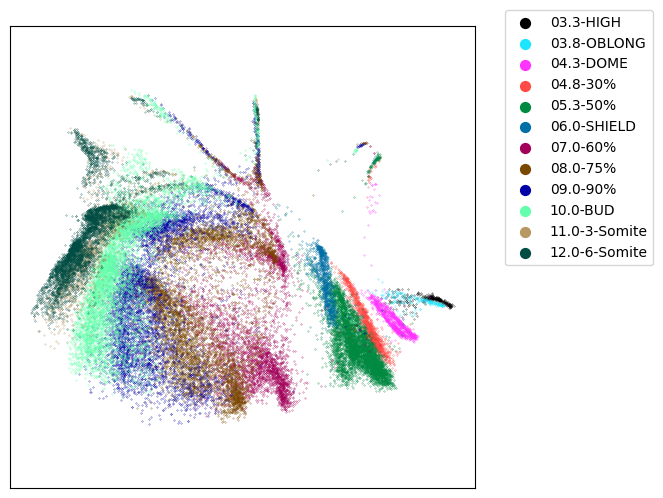

In [4]:
emb_farrell = model_farrell.transform(input_farrell)
fig_farrell, ax_farrell = vv.plot_embedding(emb_farrell, labs_farrell)
ax_farrell.get_legend().remove()
ax_farrell.set_title('Farrell: ViVAE with cosine-MDS')
fig_farrell.savefig('cosine_farrell_labels.png', dpi=600)

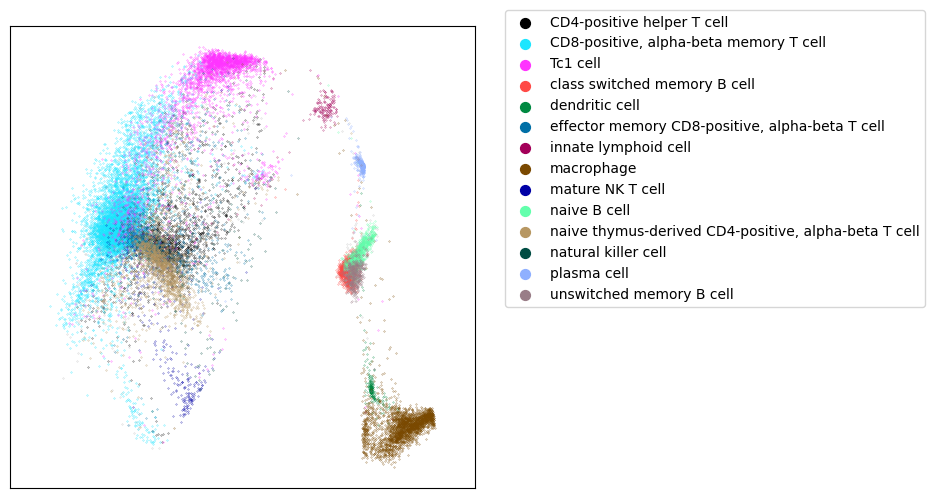

In [5]:
emb_reed = model_reed.transform(input_reed)
fig_reed, ax_reed = vv.plot_embedding(emb_reed, labs_reed, unassigned='unknown')
ax_reed.get_legend().remove()
ax_reed.set_title('Reed: ViVAE with cosine-MDS')
fig_reed.savefig('cosine_reed_labels.png', dpi=600)

We proceed to compute and plot encoder indicatrices to reveal latent space distortions.

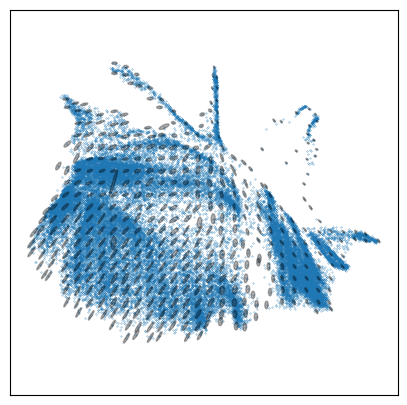

In [6]:
ei_farrell = model_farrell.encoder_indicatrices(X=input_farrell, radius=1e-3, n_steps=30)
fig_farrel_ei, ax_farrell_ei = vv.plot_indicatrices(ei_farrell, scale_factor=3e2, show=True)
ax_farrell_ei.set_title('Latent space distortions')
fig_farrel_ei.savefig('cosine_farrell_indicatrices.png', dpi=600)

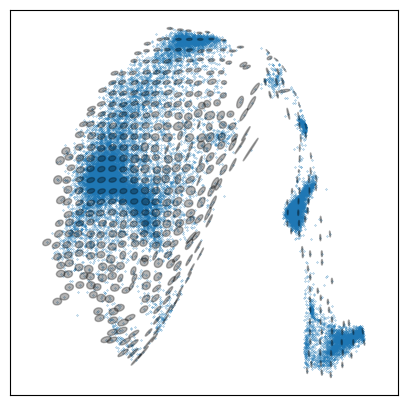

In [7]:
ei_reed = model_reed.encoder_indicatrices(X=input_reed, radius=1e-4, n_steps=30)
fig_reed_ei, ax_reed_ei = vv.plot_indicatrices(ei_reed, scale_factor=1e3, show=True)
ax_reed_ei.set_title('Latent space distortions')
fig_reed_ei.savefig('cosine_reed_indicatrices.png', dpi=600)

In [8]:
emb_farrell = model_farrell.transform(input_farrell)
fig_farrell, ax_farrell = vv.plot_embedding(emb_farrell, labs_farrell, show=False)
fig_farrell.savefig('cosine_farrell_legend.png', dpi=600, bbox_inches='tight')

In [9]:
emb_reed = model_reed.transform(input_reed)
fig_reed, ax_reed = vv.plot_embedding(emb_reed, labs_reed, show=False, unassigned='unknown')
fig_reed.savefig('cosine_reed_legend.png', dpi=600, bbox_inches='tight')